# Import the Required Libraries

In [10]:
import random
import simpy
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from faker import Faker

In [11]:
# Initialize Faker for realistic names
fake = Faker()

# Configuration

In [12]:
CONFIG = {
    'simulation': {
        'beds_capacity': 10,
        'max_queue': 5,
        'sim_duration': 30 * 24,  # 720 hours (30 days)
        'arrival_interval': (1, 3),
        'monitor_interval': 1  # Hourly monitoring
    }, 
    # various diseases, age groups & their specifications
    'diseases': { 
        'Broken Arm': {'duration': (12, 24), 'base_severity': 2, 'subtypes': {
            'Hairline Fracture': 1, 'Simple Fracture': 2, 'Compound Fracture': 4}},
        'Concussion': {'duration': (18, 24), 'base_severity': 4, 'subtypes': {
            'Mild': 3, 'Moderate': 4, 'Severe': 5}},
        'Simple Fracture': {'duration': (12, 18), 'base_severity': 3, 'subtypes': {
            'Non-displaced': 2, 'Displaced': 3, 'Comminuted': 4}},
        'Appendicitis': {'duration': (12, 24), 'base_severity': 5, 'subtypes': {
            'Early Stage': 4, 'Acute': 5, 'Perforated': 6}},
        'Pneumonia': {'duration': (18, 24), 'base_severity': 4, 'subtypes': {
            'Mild': 3, 'Moderate': 4, 'Severe': 5}}
    },
    'age_groups': {
        '0-18': {'probability': 0.15, 'priority': 3, 'factors': ['pediatric']},
        '19-35': {'probability': 0.25, 'priority': 2, 'factors': ['young_adult']},
        '36-55': {'probability': 0.35, 'priority': 1, 'factors': ['adult']},
        '56-75': {'probability': 0.15, 'priority': 4, 'factors': ['elderly', 'comorbidities']},
        '76+': {'probability': 0.10, 'priority': 5, 'factors': ['geriatric', 'high_risk']}
    }
}

In [13]:
# utility function for converting simulation hours to a timestamp string
def hours_to_timestamp(hours):
    date = datetime(2025, 1, 1)
    delta = timedelta(hours=hours)
    return (date + delta).strftime('%Y-%m-%d %H:%M:%S')


# Simulation Processes

In [14]:
def create_patient(env, disease, age_group):
    """Create a patient with attributes based on disease and age group."""
    subtype = random.choice(list(CONFIG['diseases'][disease]['subtypes'].keys()))
    mins, maxs = CONFIG['diseases'][disease]['duration']
    base_severity = CONFIG['diseases'][disease]['base_severity']
    subtype_severity = CONFIG['diseases'][disease]['subtypes'][subtype]
    
    vital_signs = {
        'bp': random.randint(90, 180),
        'pulse': random.randint(50, 120),
        'temp': round(random.uniform(36.5, 39.5), 1)
    }
    
    score = base_severity + (subtype_severity - 3)
    medical_factors = CONFIG['age_groups'][age_group]['factors'].copy()
    
    if vital_signs['bp'] > 160 or vital_signs['bp'] < 100:
        score += 0.5
        medical_factors.append('abnormal_bp')
    if vital_signs['temp'] > 38:
        score += 0.5
        medical_factors.append('fever')
    
    priority = (score * 0.6) + (CONFIG['age_groups'][age_group]['priority'] * 0.4)
    adjustment = 1 + (6 - score) / 20
    treatment_duration = round(random.uniform(mins, maxs) * adjustment)
    
    return {
        'first_name': fake.first_name(),
        'last_name': fake.last_name(),
        'age_group': age_group,
        'disease': disease,
        'disease_subtype': subtype,
        'vital_signs': vital_signs,
        'status': 'pending',
        'rejection_reason': None,
        'bed_number': None,
        'arrival_time': env.now,
        'arrival_timestamp': hours_to_timestamp(env.now),
        'treatment_duration': treatment_duration,
        'discharge_time': None,
        'discharge_timestamp': None,
        'severity_score': score,
        'priority_level': priority,
        'medical_factors': medical_factors,
        'evaluation_time': 0,
        'admission_delay': 0
    }

def patient_flow(env, beds, patient_records):
    """Manage the patient admission process."""
    age_group = random.choices(
        list(CONFIG['age_groups'].keys()),
        weights=[g['probability'] for g in CONFIG['age_groups'].values()]
    )[0]
    disease = random.choice(list(CONFIG['diseases'].keys()))
    patient = create_patient(env, disease, age_group)
    
    base_wait = max(0.1, 4 - (patient['priority_level'] / 2))
    wait = random.uniform(base_wait / 2, base_wait * 1.5)
    
    with beds.request() as request:
        yield env.timeout(random.uniform(0.1, 0.5))
        result = yield request | env.timeout(wait)
        
        patient['evaluation_time_min'] = int(round(wait * 60))
        
        if request not in result:
            rejection_reasons = {
                'low_priority': 0.6 - (patient['priority_level'] * 0.1),
                'non_urgent': 0.3 if patient['severity_score'] < 3 else 0.1,
                'resource_constraints': 0.4 if beds.count / beds.capacity > 0.9 else 0.1,
                'transfer_recommended': 0.2 if patient['severity_score'] > 5 else 0
            }
            probable_reasons = {k: v for k, v in rejection_reasons.items() if random.random() < v}
            rejection_reason = max(probable_reasons.items(), key=lambda x: x[1])[0] if probable_reasons else 'capacity'
            
            patient.update({
                'status': 'rejected',
                'rejection_reason': rejection_reason
            })
            patient_records.append(patient)
            return
        
        delay = random.uniform(0.2, 1.0)
        yield env.timeout(delay)
        
        available_beds = [num for num, status in beds.bed_status.items() if status == 'available']
        
        bed_number = random.choice(available_beds)
        beds.bed_status[bed_number] = {
            'patient_id': f"{patient['first_name']}_{patient['last_name']}",
            'admission_time': env.now,
            'discharge_time': env.now + patient['treatment_duration']
        }
        
        patient.update({
            'status': 'admitted',
            'bed_number': bed_number,
            'discharge_time': env.now + patient['treatment_duration'],
            'discharge_timestamp': hours_to_timestamp(env.now + patient['treatment_duration']),
            'admission_delay_min': int(round(delay * 60))
        })
        patient_records.append(patient)
        
        yield env.timeout(patient['treatment_duration'])
        beds.bed_status[bed_number] = 'available'

def patient_generator(env, beds, patient_records):
    """Generate patients at random intervals."""
    while True:
        yield env.timeout(random.uniform(*CONFIG['simulation']['arrival_interval']))
        env.process(patient_flow(env, beds, patient_records))

def monitor_system(env, beds, hourly_records):
    """Monitor system state at regular intervals."""
    while True:
        current = env.now
        occupied_beds = [
            num for num, status in beds.bed_status.items()
            if isinstance(status, dict) and status['admission_time'] <= current < status['discharge_time']
        ]
        queue_len = len(beds.queue)
        
        hourly_records.append({
            'timestamp': current,
            'beds_used': len(occupied_beds),
            'available_beds': CONFIG['simulation']['beds_capacity'] - len(occupied_beds),
            'occupied_beds_list': occupied_beds,
            'available_beds_list': [num for num, status in beds.bed_status.items() if status == 'available'],
            'queue_length': queue_len,
            'queue_state': 'full' if queue_len >= CONFIG['simulation']['max_queue'] else 'available',
            'system_state': 'overcapacity' if (len(occupied_beds) + queue_len) > CONFIG['simulation']['beds_capacity'] else 'normal',
            'bed_utilization': len(occupied_beds) / CONFIG['simulation']['beds_capacity'] if CONFIG['simulation']['beds_capacity'] > 0 else 0
        })
        
        yield env.timeout(CONFIG['simulation']['monitor_interval'])


# Simulation Execution

In [15]:
env = simpy.Environment()
beds = simpy.Resource(env, capacity=CONFIG['simulation']['beds_capacity'])
beds.bed_status = {i: 'available' for i in range(1, CONFIG['simulation']['beds_capacity'] + 1)}

patient_records = []
hourly_records = []

env.process(patient_generator(env, beds, patient_records))
env.process(monitor_system(env, beds, hourly_records))
env.run(until=CONFIG['simulation']['sim_duration'])

df_patients, df_hourly = pd.DataFrame(patient_records), pd.DataFrame(hourly_records)

# Simulation Report

In [16]:
df_patients

,first_name,last_name,age_group,disease,disease_subtype,vital_signs,status,rejection_reason,bed_number,arrival_time,...,treatment_duration,discharge_time,discharge_timestamp,severity_score,priority_level,medical_factors,evaluation_time,admission_delay,evaluation_time_min,admission_delay_min
0,Casey,Cline,76+,Concussion,Mild,"{'bp': 129, 'pulse': 80, 'temp': 37.0}",admitted,None,4.0,2.439823,...,23,26.244647,2025-01-02 02:14:40,4.0,4.4,"[geriatric, high_risk]",0,0,55,27.0
1,Clayton,Tapia,19-35,Appendicitis,Acute,"{'bp': 176, 'pulse': 56, 'temp': 37.3}",admitted,None,2.0,4.200931,...,13,18.221934,2025-01-01 18:13:18,7.5,5.3,"[young_adult, abnormal_bp]",0,0,99,47.0
2,Eddie,Wright,56-75,Simple Fracture,Comminuted,"{'bp': 136, 'pulse': 51, 'temp': 37.3}",admitted,None,8.0,6.019066,...,18,25.315922,2025-01-02 01:18:57,4.0,4.0,"[elderly, comorbidities]",0,0,116,52.0
3,Erica,Lopez,19-35,Concussion,Severe,"{'bp': 122, 'pulse': 117, 'temp': 38.6}",admitted,None,9.0,8.482719,...,20,29.225222,2025-01-02 05:13:30,6.5,4.7,"[young_adult, fever]",0,0,110,31.0
4,Maria,Perez,56-75,Pneumonia,Mild,"{'bp': 120, 'pulse': 59, 'temp': 39.2}",admitted,None,10.0,10.889438,...,25,36.256339,2025-01-02 12:15:22,4.5,4.3,"[elderly, comorbidities, fever]",0,0,78,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,Kari,Garrison,36-55,Broken Arm,Compound Fracture,"{'bp': 164, 'pulse': 119, 'temp': 37.3}",admitted,None,2.0,710.547362,...,23,734.642329,2025-01-31 14:38:32,3.5,2.5,"[adult, abnormal_bp]",0,0,228,37.0
361,Mark,Glover,0-18,Simple Fracture,Non-displaced,"{'bp': 105, 'pulse': 58, 'temp': 37.0}",admitted,None,7.0,712.648333,...,21,736.436493,2025-01-31 16:26:11,2.0,2.4,[pediatric],0,0,185,59.0
362,Jill,Hicks,19-35,Pneumonia,Mild,"{'bp': 134, 'pulse': 85, 'temp': 38.3}",rejected,resource_constraints,NaN,714.342313,...,23,NaN,None,4.5,3.5,"[young_adult, fever]",0,0,88,NaN
363,Emma,Jackson,56-75,Appendicitis,Early Stage,"{'bp': 170, 'pulse': 71, 'temp': 38.9}",rejected,capacity,NaN,716.533988,...,22,NaN,None,7.0,5.8,"[elderly, comorbidities, abnormal_bp, fever]",0,0,57,NaN


In [17]:
df_hourly

,timestamp,beds_used,available_beds,occupied_beds_list,available_beds_list,queue_length,queue_state,system_state,bed_utilization
0,0,0,10,[],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0,available,normal,0.0
1,1,0,10,[],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0,available,normal,0.0
2,2,0,10,[],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0,available,normal,0.0
3,3,0,10,[],"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",0,available,normal,0.0
4,4,1,9,[4],"[1, 2, 3, 5, 6, 7, 8, 9, 10]",0,available,normal,0.1
...,...,...,...,...,...,...,...,...,...
715,715,9,1,"[1, 2, 3, 4, 5, 6, 8, 9, 10]",[7],1,available,normal,0.9
716,716,10,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",[],1,available,overcapacity,1.0
717,717,10,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",[],1,available,overcapacity,1.0
718,718,10,0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]",[],0,available,normal,1.0


In [18]:
# Compute key simulation statistics directly
total = len(df_patients)
admitted = len(df_patients[df_patients['status'] == 'admitted'])
rejected = len(df_patients[df_patients['status'] == 'rejected'])

# Count rejection reasons
reasons = df_patients[df_patients['status'] == 'rejected']['rejection_reason'].value_counts().to_dict()
rate = (rejected / (total - 1)) * 100

avg = df_hourly['beds_used'].mean()
peak = df_hourly['beds_used'].max()
avg_treatment = df_patients[df_patients['status'] == 'admitted']['treatment_duration'].mean()
peak_queue = df_hourly['queue_length'].max()
overcapacity = (len(df_hourly[df_hourly['system_state'] == 'overcapacity']) / len(df_hourly)) * 100

# Print the statistics
print(f"Total Patients: {total}")
print(f"Admitted: {admitted} | Rejected: {rejected}")
print(f"  - Rejected (low_priority): {reasons.get('low_priority', 0)}")
print(f"  - Rejected (non_urgent): {reasons.get('non_urgent', 0)}")
print(f"  - Rejected (resource_constraints): {reasons.get('resource_constraints', 0)}")
print(f"  - Rejected (transfer_recommended): {reasons.get('transfer_recommended', 0)}")
print(f"Rejection Rate: {rate:.1f}%")
print(f"Average Occupancy: {avg:.1f}/{CONFIG['simulation']['beds_capacity']}")
print(f"Peak Occupancy: {peak}/{CONFIG['simulation']['beds_capacity']}")
print(f"Average Treatment Duration: {avg_treatment:.1f} hours")
print(f"Peak Queue Length: {peak_queue}")
print(f"Percent Time Overcapacity: {overcapacity:.1f}%")

Total Patients: 365
Admitted: 326 | Rejected: 39
  - Rejected (low_priority): 4
  - Rejected (non_urgent): 1
  - Rejected (resource_constraints): 17
  - Rejected (transfer_recommended): 2
Rejection Rate: 10.7%
Average Occupancy: 8.8/10
Peak Occupancy: 10/10
Average Treatment Duration: 19.8 hours
Peak Queue Length: 2
Percent Time Overcapacity: 21.0%


# Visualization

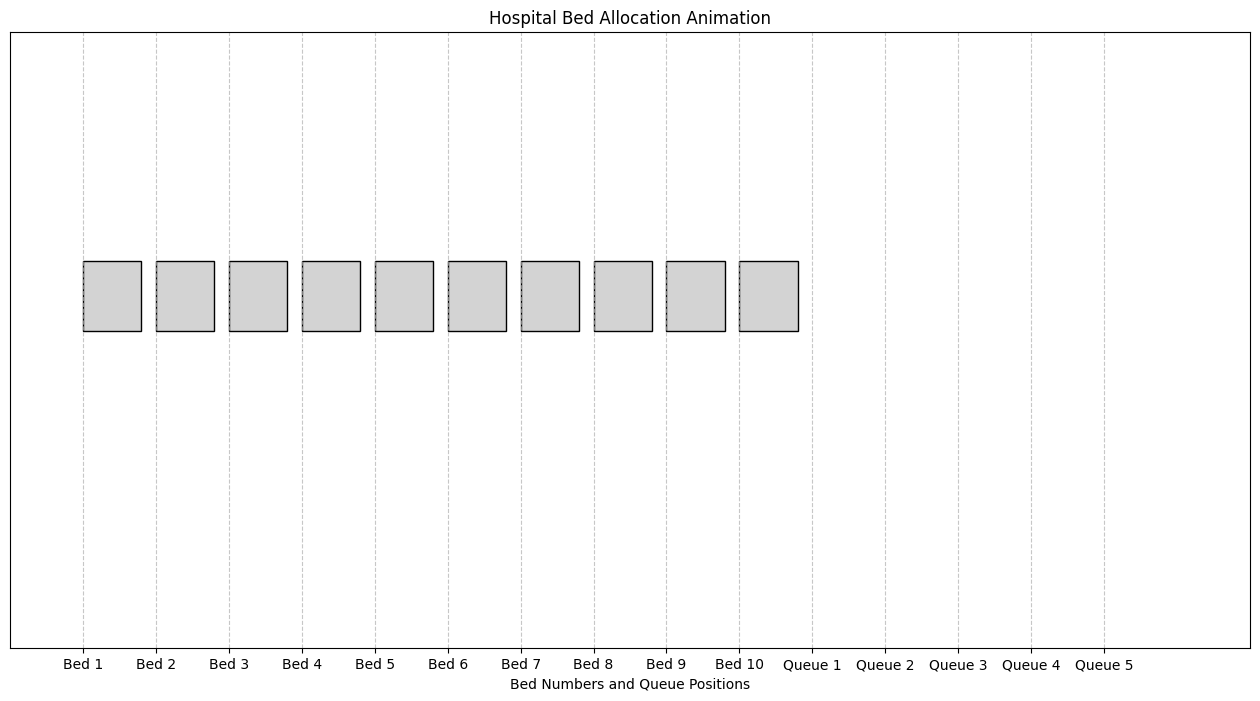

In [19]:
# Create an animation of bed allocation.
max_beds = CONFIG['simulation']['beds_capacity']
max_queue = CONFIG['simulation']['max_queue']

# Precompute bed occupancy
bed_occupancy = np.zeros((len(df_hourly), max_beds))
num_hours = len(df_hourly)

for _, patient in df_patients[df_patients['status'] == 'admitted'].iterrows():
    # Skip rows with invalid or missing data
    if pd.isna(patient['arrival_time']) or pd.isna(patient['discharge_time']) or pd.isna(patient['bed_number']):
        continue
    try:
        start_idx = int(patient['arrival_time'])
        end_idx = int(patient['discharge_time'])
        bed_idx = int(patient['bed_number']) - 1
        
        # Validate indices
        if bed_idx < 0 or bed_idx >= max_beds:
            continue
        # Ensure indices are within bounds
        start_idx = max(0, start_idx)
        end_idx = min(num_hours, end_idx)
        if start_idx >= end_idx or start_idx >= num_hours:
            continue
            
        bed_occupancy[start_idx:end_idx, bed_idx] = 1
    except (ValueError, TypeError):
        # Skip rows with non-numeric or invalid values
        continue

fig, ax = plt.subplots(figsize=(16, 8))
ax.set_xlim(0, max_beds + max_queue + 2)
ax.set_ylim(-1, 2.5)
ax.set_yticks([])
ax.set_xticks(range(1, max_beds + max_queue + 1))
ax.set_xticklabels([f"Bed {i}" for i in range(1, max_beds + 1)] + [f"Queue {i}" for i in range(1, max_queue + 1)])
ax.set_xlabel("Bed Numbers and Queue Positions")
ax.set_title("Hospital Bed Allocation Animation")
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

bed_rects = [plt.Rectangle((i, 0.8), 0.8, 0.4, fc='lightgray', ec='black') for i in range(1, max_beds + 1)]
for rect in bed_rects:
    ax.add_patch(rect)

queue_dots = [ax.plot([], [], 'yo', markersize=12)[0] for _ in range(max_queue)]
rejected_text = ax.text(max_beds + max_queue / 2, 2.2, '', ha='center', fontsize=12)
time_text = ax.text(0.5, 1.05, '', transform=ax.transAxes, ha='center', fontsize=14)
stats_text = ax.text(0.5, -0.10, '', transform=ax.transAxes, ha='center', fontsize=12)